# certifciate_quality_classifier_v4
## I will be trying to add an additional outcome in this version to either Approve, Reject or Needs Review category - using Use binary logistic + calculated thresholds (ex:0.4/0.6 bands, will use scatter plot to check where its falling and add this band that needs review)

* Importing Wine dataset and converting into a certificate decision data
* build a model using linear and logistic regression
* find optimal threshold
* find confusion matrix to decide boundaries
* plot thresolds and plot of data points
* finally mark the acccuracy

In [3]:
import pandas as pd
import numpy as np
wine_df = pd.read_csv('../ref_datasets/winequality-red.csv',sep=';')
print(wine_df.head())
wine_df['decision'] = np.where(wine_df['quality'] > 5.5, 1, 0)
print(wine_df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [4]:
#import all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# load the data into X and y

X = wine_df[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "residual sugar",
        "chlorides",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "density",
        "pH",
        "sulphates",
        "alcohol",
    ]
]
y = wine_df["decision"]  # original data only has two deicisons 0=Reject, 1=Approve

# Stratified split ensures balanced class representation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# train the model
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
)
model.fit(X_train, y_train)

# predict probability
p = model.predict_proba(X_test)[:, 1]  

# ROC-based optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, p)
youden_index = np.argmax(tpr - fpr)
optimal_thresh = thresholds[youden_index]

#percentiles based threshold
low_thresh = np.percentile(p, 40)
high_thresh = np.percentile(p, 60)

print(f"Optimal ROC threshold: {optimal_thresh:.3f}")
print(f"Percentile thresholds: Reject<{low_thresh:.3f}, Approve>{high_thresh:.3f}")

# Apply thresholds
decision = np.select(
    [
        p <= low_thresh,  # Reject
        (p > low_thresh) & (p < high_thresh),  # Review
        p >= high_thresh,  # Approve
    ],
    [0, 1, 2],
)

# accuracy and confision matrix
decided_mask = decision != 1  # Exclude review zone for accuracy
decided_accuracy = accuracy_score(
    y_test[decided_mask], np.where(decision[decided_mask] == 2, 1, 0)
)
review_rate = np.mean(decision == 1)

print(f"\nAccuracy on decided cases: {decided_accuracy:.2f}")
print(f"Review rate: {review_rate:.2f}")

#save results
results_df = pd.DataFrame(
    {
        "probability": p,
        "true_label": y_test.values,
        "decision": decision,
    }
)
results_df.to_csv("wine_decision_results.csv", index=False)
print("Results saved to 'wine_decision_results.csv'")



Optimal ROC threshold: 0.515
Percentile thresholds: Reject<0.400, Approve>0.623

Accuracy on decided cases: 0.78
Review rate: 0.20
Results saved to 'wine_decision_results.csv'


We could achieve accuracy aligning with actual deicisons around 78%, but we also have 20% of deicision under review. 
which mean these fall under review zone. lets try creating confusion matrix to dine Type1 and Type2 errors 

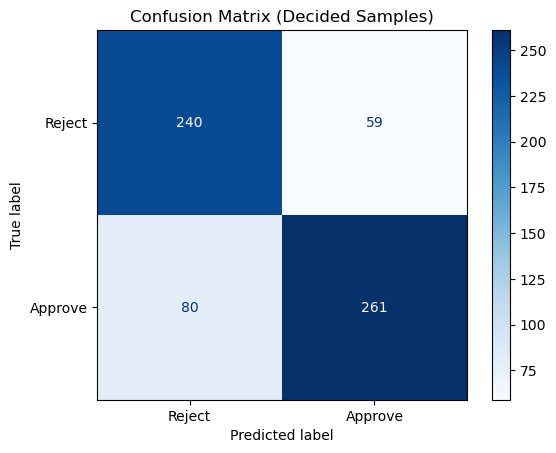

In [5]:
# Confusion matrix 
cm = confusion_matrix(
    y_test[decided_mask], np.where(decision[decided_mask] == 2, 1, 0)
)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reject", "Approve"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Decided Samples)")
plt.show()


With above confusion matrix, we could see 59 wrong approvals were made and 80 wrong rejections, this gap need to be fulfilled with review stage.

below graph we can use for adding optimal threshold - last time we created a for loop to get optimal thresold, but this time its easier to get it through ROC (Receiver Operating Characteristic curve)

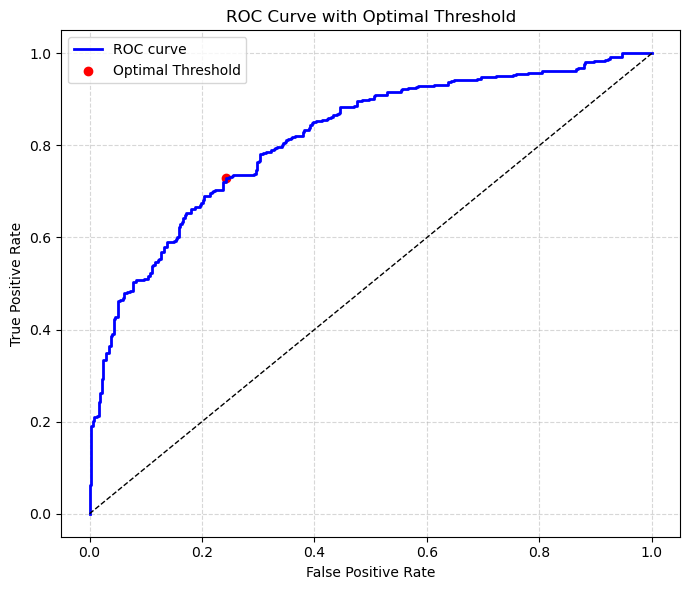

In [6]:


#ROC Curve and optimal theshold
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve")
plt.scatter(fpr[youden_index], tpr[youden_index], color="red", label="Optimal Threshold")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve with Optimal Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Below graph provides the distribution on predicted probabilities & thresolds and its density 

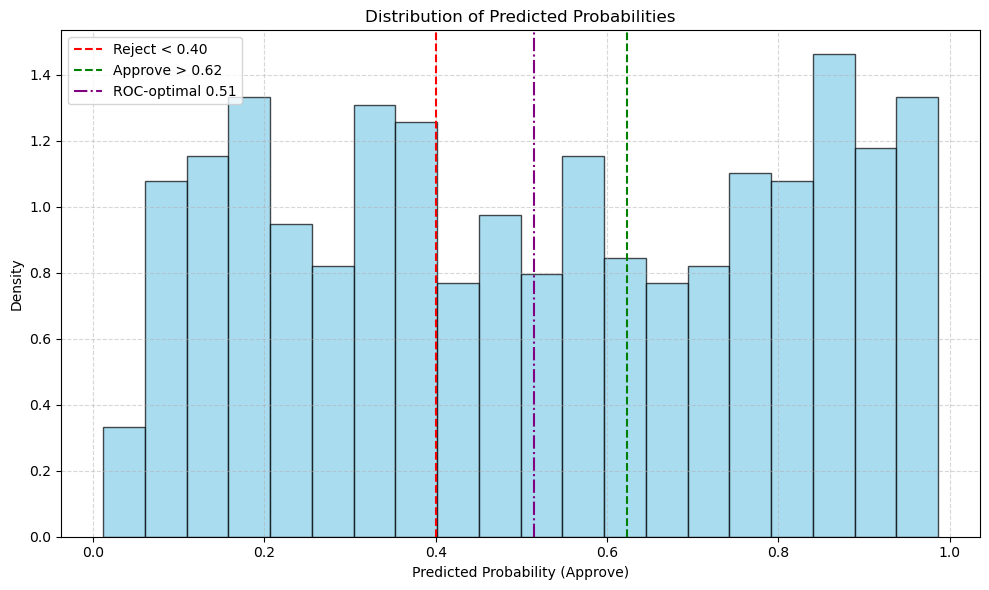

In [7]:

#Probability distribution
plt.figure(figsize=(10, 6))
plt.hist(p, bins=20, density=True, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(low_thresh, color="red", linestyle="--", label=f"Reject < {low_thresh:.2f}")
plt.axvline(high_thresh, color="green", linestyle="--", label=f"Approve > {high_thresh:.2f}")
plt.axvline(optimal_thresh, color="purple", linestyle="-.", label=f"ROC-optimal {optimal_thresh:.2f}")
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (Approve)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Now lets learn about 
##  OvR model (one vs all) 
###  - and we will just numpy instead of sklearn.
###  How it works is it actuall works same as logistic regression, but this time we will instead of calculating approval probability , 
###  will calculate probability of Review and Rejection as well.

#### I will be building 3 models for individual decisions and finally coverge it to get 3 class model.

Used 3d toolkit to represent. 

Accuracy on decided cases: 82.47%
Review rate: 58.97%


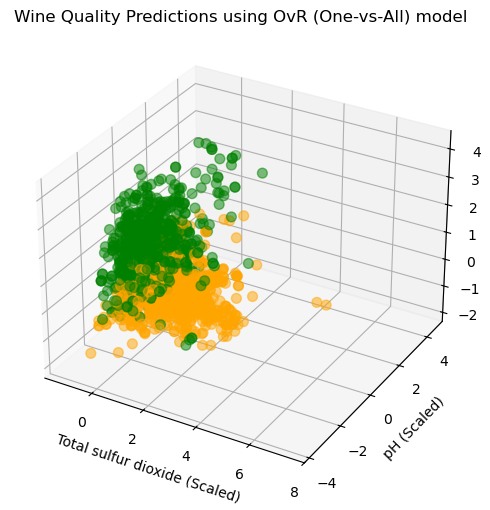

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = wine_df

# Multiclass target (based on quality score)
conditions = [
    (data['quality'] < 4),  # Rejected (0, low quality)
    (data['quality'] > 5),  # Approved (1, high quality)
    True                    # Needs Review (2, medium quality)
]
data['actual_decision'] = np.select(conditions, [0, 1, 2])

# Features (all 11) and target
X = data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
          'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
          'pH', 'sulphates', 'alcohol']].values
y = data['actual_decision'].values

# Normalize features (like your v2 scaling)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Sigmoid function (from your v2)
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip to avoid overflow

# Logistic regression gradient descent (from v2)
def train_logistic(X, y_binary, learning_rate=0.01, epochs=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for _ in range(epochs):
        z = X @ weights + bias
        probs = sigmoid(z)
        error = probs - y_binary
        grad_w = (X.T @ error) / m
        grad_b = np.mean(error)
        weights -= learning_rate * grad_w
        bias -= learning_rate * grad_b
    return weights, bias

# One-vs-all: Training three binary models
classes = [0, 1, 2]  # Rejected, Approved, Needs Review
models = []
for c in classes:
    y_binary = (y == c).astype(int)  # 1 for class c, 0 for others
    weights, bias = train_logistic(X, y_binary, learning_rate=0.01, epochs=2000)  # iter epochs for convergence
    models.append((weights, bias))

# Predict and get probs for each class, and choose highest
probs = np.zeros((X.shape[0], len(classes)))
for i, (weights, bias) in enumerate(models):
    z = X @ weights + bias
    probs[:, i] = sigmoid(z)
preds = np.argmax(probs, axis=1)

# Gray zone-If max prob < 0.6, set to Needs Review (2)
max_probs = np.max(probs, axis=1)
preds[max_probs < 0.6] = 2

# Accuracy on review cases
mask = preds != 2
accuracy = np.mean(y[mask] == preds[mask]) if np.sum(mask) > 0 else 0
print(f"Accuracy on decided cases: {accuracy:.2%}")
print(f"Review rate: {np.mean(preds == 2):.2%}")

# important drivers in 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if p == 0 else 'green' if p == 1 else 'orange' for p in preds]
ax.scatter(X[:, 6], X[:, 8], X[:, 10], c=colors, alpha=0.5, s=50)
ax.set_xlabel('Total sulfur dioxide (Scaled)')
ax.set_ylabel('pH (Scaled)')
ax.set_zlabel('Alcohol (Scaled)')
ax.set_title('Wine Quality Predictions using OvR (One-vs-All) model')
plt.show()

## The second time even though we used simple method without prebuilt functions, we were able to achieve better accuracy 
## just because we had right training data properly classified at time of training and also the method used was very simple.

#### additional analysis below, you may ignore this part, just trying view or understand some data generated above 

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotterscatter(y):
    sns.scatterplot(
        x=X[:,8],
        y=y,
        hue=p,                # color points based on p values
        palette="viridis",    # you can try 'coolwarm', 'plasma', 'turbo', etc.
    )
    plt.xlabel("pH")
    plt.ylabel("p")
    plt.title("pH vs p (colored by p values)")
    plt.show()


Training model for class 0...
Training model for class 1...
Training model for class 2...


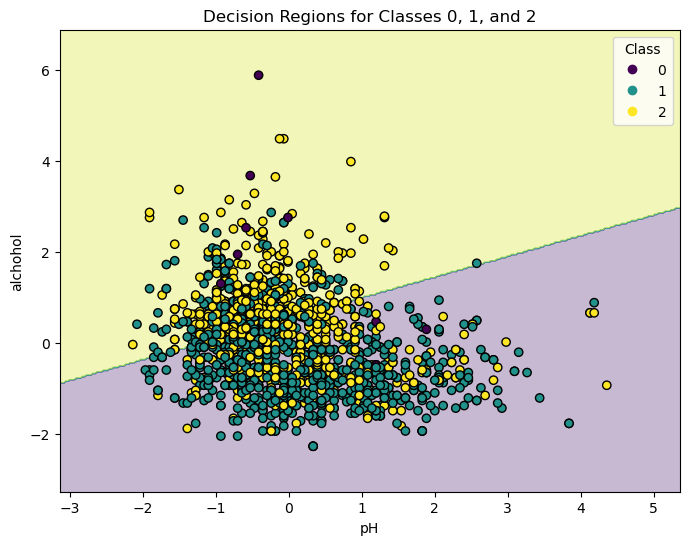

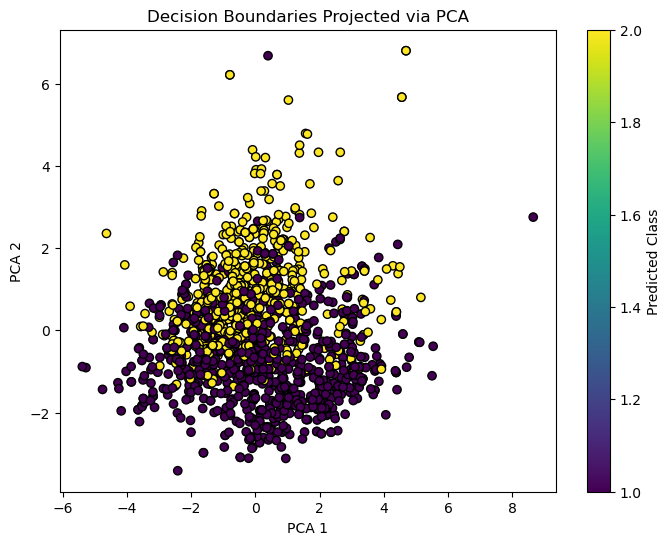

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Normalize features ---
X = (X - X.mean(axis=0)) / X.std(axis=0)

# --- Sigmoid ---
def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Prevent overflow

# --- Plotting function ---
def plotterscatter(X, y_pred, epoch):
    sns.scatterplot(
        x=X[:,8],
        y=y_pred,
        hue=y_pred,
        palette="viridis"
    )
    plt.xlabel("pH")
    plt.ylabel("Predicted Probability")
    plt.title(f"pH vs Predicted Probabilities (Epoch {epoch})")
    plt.show()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_decision_regions(X, y, models, feature_names=("pH", "feature2")):
    # Convert to numpy if it's a DataFrame
    if hasattr(X, "values"):
        X = X.values
    
    # Use only first two features for 2D plotting
    X_plot = X[:, :2]
    
    # Create a meshgrid over the feature space
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    # Flatten grid for predictions
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Compute probabilities for each class
    probs = []
    for weights, bias in models:
        # Adjust if weights have more features
        z = grid @ weights[:2] + bias
        probs.append(1 / (1 + np.exp(-z)))  # sigmoid
    probs = np.array(probs)
    
    # Pick the class with the highest probability at each point
    class_map = np.argmax(probs, axis=0).reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, class_map, alpha=0.3, cmap="viridis")
    
    # Scatter actual data points
    scatter = plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, cmap="viridis", edgecolor="k")
    plt.legend(*scatter.legend_elements(), title="Class")
    
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Regions for Classes 0, 1, and 2")
    plt.show()
from sklearn.decomposition import PCA

def plot_pca_decision(X, y, models):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Predict class using full model
    probs = []
    for weights, bias in models:
        z = X @ weights + bias
        probs.append(1 / (1 + np.exp(-z)))
    probs = np.array(probs)
    preds = np.argmax(probs, axis=0)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=preds, cmap="viridis", edgecolor="k")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("Decision Boundaries Projected via PCA")
    plt.colorbar(label="Predicted Class")
    plt.show()

# --- Logistic Regression (binary) ---
def train_logistic(X, y_binary, learning_rate=0.01, epochs=1000, plot_interval=200):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for epoch in range(epochs):
        z = X @ weights + bias
        probs = sigmoid(z)
        
        # Gradient descent
        error = probs - y_binary
        grad_w = (X.T @ error) / m
        grad_b = np.mean(error)
        weights -= learning_rate * grad_w
        bias -= learning_rate * grad_b
    return weights, bias

# --- One-vs-all ---
classes = [0, 1, 2]  # Rejected, Approved, Needs Review
models = []

for c in classes:
    y_binary = (y == c).astype(int)
    print(f"Training model for class {c}...")
    weights, bias = train_logistic(X, y_binary, learning_rate=0.01, epochs=2000)
    models.append((weights, bias))

plot_decision_regions(X, y, models, feature_names=["pH", "alchohol"])
plot_pca_decision(X, y, models)
